In [12]:
import sys
import os
from pathlib import Path
import pandas as pd
import numpy as np


sys.path.insert(0, str(Path("exact_solver")))
from exact_solver.runner import *

In [13]:

instances = [Instance("instance_4th5th_2026sem1"), Instance("instance_2026sem1"), Instance("instance_2025sem2")]
experiments = []
objectives = ["except_timeslots", "elective_overlap", "prof_days", "preference"]

In [14]:
instance = instances[0]
folder = f"results\\{instance.name}\\weighted_sum"


for file in os.listdir(folder):
    filepath = os.path.join(folder, file)
    experiment = Experiment(instance, filepath)
    experiments.append(experiment)


In [15]:
def display_experiments(experiments):
    
    rows = []

    for exp in experiments:
        rows.append({
            "exec_time (s)" : exp.exec_time,
        })

        for obj in exp.objectives:
            # if obj["weight"] > 0 or obj["upper_bound"] is not None:
            for arg in ["value"]:
                    # if obj[arg] is not None:
                    rows[-1][f"{arg} {obj["name"]}"] = obj[arg]
                # rows[-1][obj["name"] + "\nupper_bound"] = obj["upper_bound"]

    df = pd.DataFrame(rows)
    df = df.round(2)

    return df


df = display_experiments([e for e in experiments if e.instance == instance])
df

,exec_time (s),value except_timeslots,value elective_overlap,value prof_days,value preference
0,7.31,8.0,46.0,25.0,358.0
1,8.37,8.0,30.0,24.0,365.0
2,2.74,46.0,12.0,24.0,301.0
3,22.15,48.0,34.0,23.0,297.0
4,1.78,46.0,32.0,24.0,295.0
5,5.66,24.0,42.0,25.0,295.0
6,4.19,50.0,18.0,25.0,295.0
7,7.92,48.0,38.0,24.0,295.0
8,33.01,8.0,42.0,23.0,356.0
9,6.02,8.0,38.0,24.0,314.0


In [16]:


def display_objectives_ranges(df):
    rows = []

    for obj in objectives:
        # Drop NaN and None values safely
        series = df[f"value {obj}"].dropna()

        if len(series) == 0:
            # Handle case where all values are NaN/None
            max_obj, min_obj, range_obj = np.nan, np.nan, np.nan
        else:
            max_obj = series.max()
            min_obj = series.min()
            range_obj = max_obj - min_obj

        rows.append({
            "objective": obj,
            "max": max_obj,
            "min": min_obj,
            "range": range_obj,
        })

    df2 = pd.DataFrame(rows)
    df2 = df2.round(2)

    return df2


df2 = display_objectives_ranges(df)
df2

,objective,max,min,range
0,except_timeslots,62.0,8.0,54.0
1,elective_overlap,50.0,12.0,38.0
2,prof_days,25.0,23.0,2.0
3,preference,378.0,295.0,83.0


#### augmecon

In [17]:
ranges = df2.set_index("objective")["range"].to_dict()
mins = df2.set_index("objective")["min"].to_dict()
maxs = df2.set_index("objective")["max"].to_dict()

obj1 = "except_timeslots"
constr_objs = {
    o : {
        "current_UB": maxs[o],
        "min": mins[o],
        "max": maxs[o],
        "range": ranges[o],
        "num_steps": 9+1 if o != "prof_days" else 2
        }
    for o in objectives if o != obj1}

for o in constr_objs.values():
    o["step_size"] = o["range"]/(o["num_steps"]-1)


# prev_solution = None

base_cmd = [
            "python", "exact_solver/runner.py",
            "--instance", instance.name, "--method", "augmecon",
            "--priorities", "0 1 2 3", "--ranges", " ".join(str(int(v)) for v in ranges.values()),            
        ]



In [18]:
print(*constr_objs.items(), sep='\n')

('elective_overlap', {'current_UB': 50.0, 'min': 12.0, 'max': 50.0, 'range': 38.0, 'num_steps': 10, 'step_size': 4.222222222222222})
('prof_days', {'current_UB': 25.0, 'min': 23.0, 'max': 25.0, 'range': 2.0, 'num_steps': 2, 'step_size': 2.0})
('preference', {'current_UB': 378.0, 'min': 295.0, 'max': 378.0, 'range': 83.0, 'num_steps': 10, 'step_size': 9.222222222222221})


In [19]:
o = constr_objs["preference"]
o["current_UB"] = o["max"]

constr_objs["elective_overlap"]["current_UB"] = 12
constr_objs["prof_days"]["current_UB"] = 23

for i in range(o["num_steps"]):
    
    bounds_cmd = ["--upper_bounds", "None", " ".join(str(int(o["current_UB"])) for o in constr_objs.values())]

    print(" ".join(base_cmd + bounds_cmd))

    o["current_UB"] = o["current_UB"] - o["step_size"]
    
print('\n')

python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 378
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 368
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 359
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 350
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 341
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --method augmecon --priorities 0 1 2 3 --ranges 54 38 2 83 --upper_bounds None 12 23 331
python exact_solver/runner.py --instance instance_4th5th_2026sem1 --me

### AUGMECON results

In [20]:
instance = instances[0]
folder = f"results\\{instance.name}\\augmecon"


for file in os.listdir(folder):
    filepath = os.path.join(folder, file)
    experiment = Experiment(instance, filepath)
    experiments.append(experiment)


In [21]:
df = display_experiments([e for e in experiments if e.instance == instance and e.method == "augmecon"])
df


,exec_time (s),value except_timeslots,value elective_overlap,value prof_days,value preference
0,11.74,32.0,12.0,23.0,305.0
1,12.98,28.0,12.0,23.0,307.0
2,12.58,24.0,12.0,23.0,309.0
3,23.96,24.0,12.0,23.0,309.0
4,16.59,22.0,12.0,23.0,312.0
...,...,...,...,...,...
172,12.90,16.0,30.0,23.0,304.0
173,64.98,16.0,28.0,23.0,307.0
174,13.37,14.0,30.0,23.0,308.0
175,30.57,14.0,28.0,23.0,310.0


In [35]:
df_filtrado = df[df['value prof_days'] == 23]
points = df_filtrado[["value except_timeslots", "value elective_overlap", "value preference"]].to_numpy()

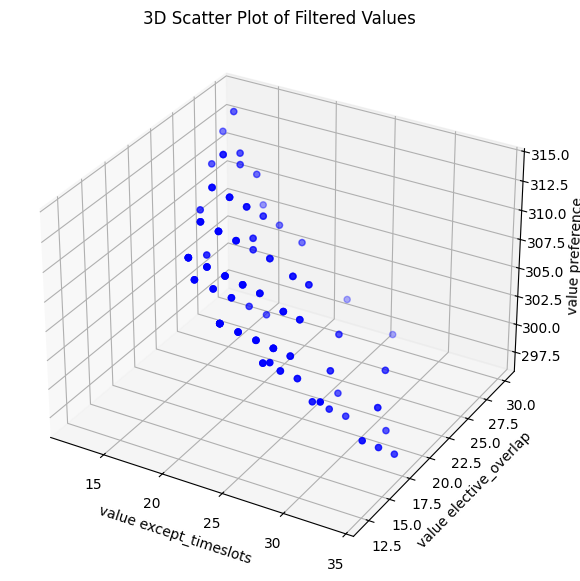

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear figura y eje 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Graficar puntos
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', marker='o')

# Etiquetas de los ejes
ax.set_xlabel("value except_timeslots")
ax.set_ylabel("value elective_overlap")
ax.set_zlabel("value preference")

# Título
ax.set_title("3D Scatter Plot of Filtered Values")

plt.show()


In [39]:
# print(*[" ".join([str(int(p)) for p in row]) for row in points], sep='\n')